In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from ctisim import LogisticTrap, ITL_AMP_GEOM, SegmentSimulator, OutputAmplifier, LinearTrap
from ctisim.fitting import CTIModel, FixedLossModel, BiasDriftModel, SimulatedTrapModel

# ITL Full Deferred Charge Model

In [39]:
## Overscan results header
overscan_results = '../examples/data/ITL_overscan_results.fits'
hdul = fits.open(overscan_results)

prihdr = hdul[0].header
print(repr(prihdr), '\n')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATASEC = '[4:512,1:2000]'                                                      
NAMPS   =                   16                                                  
CHECKSUM= 'NZoQQWoPNWoPNWoP'   / HDU checksum updated 2019-11-14T15:58:10       
DATASUM = '0       '           / data unit checksum updated 2019-11-14T15:58:10  



Text(0.5, 0, 'Signal [e-]')

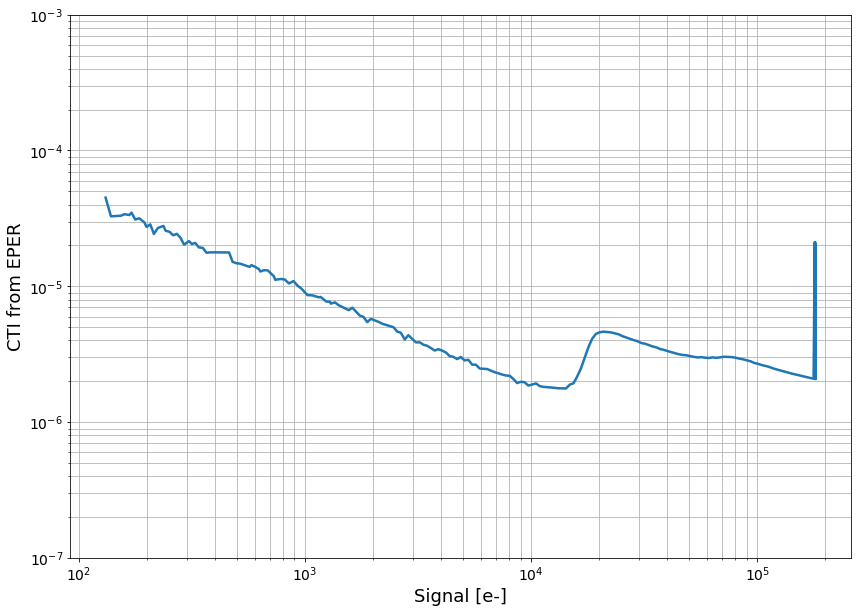

In [43]:
##CTI vs Signal for Data
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

amp = 7
data = hdul[amp].data
signal_all = data['FLUX']
indices = np.argsort(signal_all)
signal_data = signal_all[indices]

last_pix = data['MEANROW'][:, 511]
oscan1 = data['MEANROW'][:, 512]
#oscan2 = data['MEANROW'][:, 513]
oscan2 = 0
cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [63]:
## Low signal trapping
mcmc_results = fits.open('../examples/data/ITL_overscan_mcmc_results.fits')
mcmc_data = mcmc_results[1].data

print(repr(mcmc_results[1].header))

## Trap parameters
amp=7
cti = mcmc_data['CTI'][amp-1]
size = mcmc_data['TRAP_SIZE'][amp-1]
emission_time = mcmc_data['TRAP_TAU'][amp-1]
scaling = mcmc_data['TRAP_DFACTOR'][amp-1]
lowsignal_trap = LinearTrap(size, emission_time, 1, scaling, 0.0)
print(emission_time)

## Bias hysteresis parameters
drift_scale = mcmc_data['DRIFT_SIZE'][amp-1]
decay_time = mcmc_data['DRIFT_TAU'][amp-1]
threshold = mcmc_data['DRIFT_THRESHOLD'][amp-1]
output_amplifier = OutputAmplifier(1.0, 0.0, offset=0.0, drift_scale=drift_scale,
                                   decay_time=decay_time, threshold=threshold)


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   28 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'CTI     '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DRIFT_SIZE'                                                          
TFORM2  = 'E       '                                                            
TTYPE3  = 'DRIFT_TAU'       

Text(0.5, 0, 'Signal [e-]')

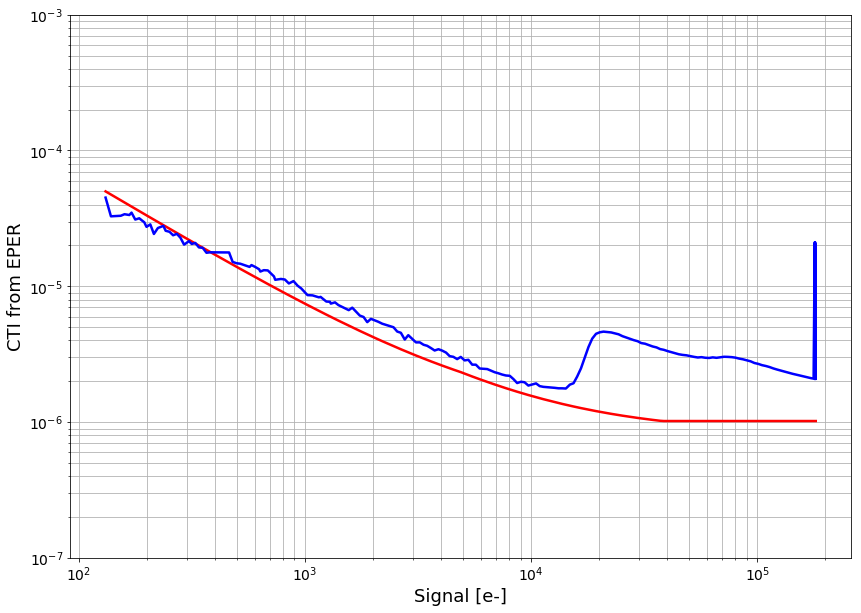

In [64]:
imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=lowsignal_trap)
flat.ramp_exp(signal_data)

im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=False)

last_pix = im[:, 511]
oscan1 = im[:, 512]
cti_model = (oscan1/(512*last_pix))
      
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signal_data, cti_model, linewidth=2.5, color='red')
ax.plot(signal_data, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

Text(0.5, 0, 'Signal [e-]')

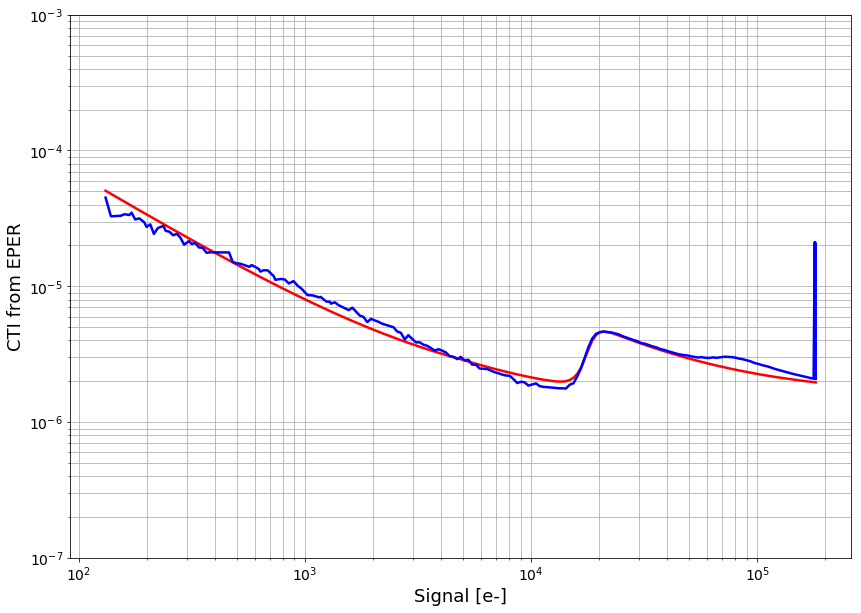

In [66]:
midsignal_trap = LogisticTrap(40, 0.5, 1, 18000., 0.0010)

imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[lowsignal_trap, midsignal_trap])
flat.ramp_exp(signal_data)


im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

last_pix = im[:, 511]
oscan1 = im[:, 512]
cti_model = (oscan1)/(512*last_pix)
      
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signal_data, cti_model, linewidth=2.5, color='red')
ax.plot(signal_data, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Testing Simple Overscan Models

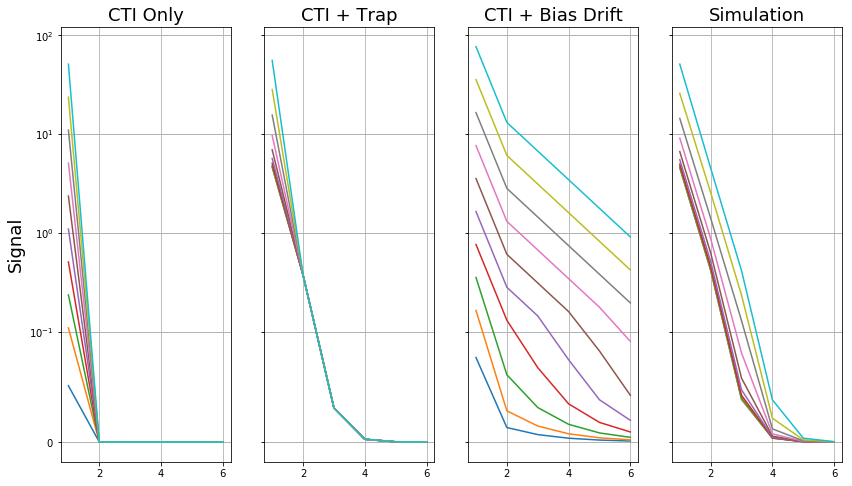

In [11]:
signals = np.logspace(2, 5, 10)
start = 1
stop = 6

fig, axes = plt.subplots(1, 4, figsize=(14, 8), sharey=True)
axes = axes.flatten()

oscan_col = np.arange(start, stop+1)

## CTI only model
params = [1.E-6]
model = CTIModel(params, 512)
r = model.results(signals, stop=stop)
for i, signal in enumerate(signals):
    axes[0].plot(oscan_col, r[i, :])
axes[0].set_ylabel('Signal', fontsize=18)
axes[0].set_title('CTI Only', fontsize=18)
axes[0].set_yscale('symlog', linthreshy=0.1)
axes[0].grid(True, which='both')
    
## Trap fixed loss model
params = [1.E-6, 5.0, 0.4]
model = FixedLossModel(params, 512)
r = model.results(signals, stop=stop)
for i, signal in enumerate(signals):
    axes[1].plot(oscan_col, r[i, :])
axes[1].set_title('CTI + Trap', fontsize=18)
axes[1].set_yscale('symlog', linthreshy=0.1)
axes[1].grid(True, which='both')

    
## Bias drift proportional loss
params = [1.E-6, 0.0005, 1.5]
model = BiasDriftModel(params, 512)
r = model.results(signals, stop=stop)
for i, signal in enumerate(signals):
    axes[2].plot(oscan_col, r[i, :])
axes[2].set_title('CTI + Bias Drift', fontsize=18)
axes[2].set_yscale('symlog', linthreshy=0.1)
axes[2].grid(True, which='both')

## Simulation
params = [1.E-6, 5.0, 0.4, 0.1, 0.0]
output_amplifier = OutputAmplifier(1.0, 0.0)
model = SimulatedTrapModel(params, ITL_AMP_GEOM, LinearTrap, output_amplifier)
r = model.results(signals, stop=stop)
for i, signal in enumerate(signals):
    axes[3].plot(oscan_col, r[i,:])         
axes[3].set_title('Simulation', fontsize=18)
axes[3].set_yscale('symlog', linthreshy=0.1)
axes[3].grid(True, which='both')

Text(0.5, 0, 'Signal [e-]')

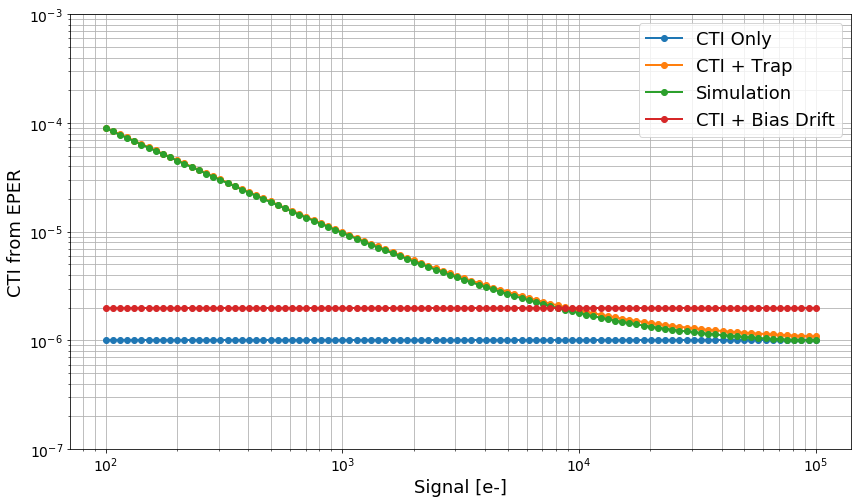

In [7]:
signals = np.logspace(2, 5, 100)
start = 1
stop = 5

fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharey=True)

oscan_col = np.arange(start, stop+1)

## CTI only model
params = [1.E-6]
model = CTIModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=2, marker='o', label='CTI Only')

## Trap fixed loss model
params = [1.E-6, 5.0, 0.4]
model = FixedLossModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=2, marker='o', label='CTI + Trap')

## Simulation
params = [1.E-6, 5.0, 0.4, 0.1, 0.0]
output_amplifier = OutputAmplifier(1.0, 0.0)
model = SimulatedTrapModel(params, ITL_AMP_GEOM, LinearTrap, output_amplifier)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=2, marker='o', label='Simulation')

## Bias drift proportional loss
params = [1.E-6, 0.001, 1.5]
model = BiasDriftModel(params, 512)
r = model.results(signals, stop=stop)
cti_result = r[:, 0]/(signals*512)
ax.plot(signals, cti_result, linewidth=2, marker='o', label='CTI + Bias Drift')

ax.legend(fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)